In [ ]:
!wget https://pixeldrain.com/api/file/wnUrWG2k?download
!unzip wnUrWG2k?download

--2023-07-04 19:47:29--  https://pixeldrain.com/api/file/wnUrWG2k?download
Resolving pixeldrain.com (pixeldrain.com)... 23.175.1.76, 23.175.1.95, 2607:9280:a::76, ...
Connecting to pixeldrain.com (pixeldrain.com)|23.175.1.76|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-07-04 19:47:29 ERROR 404: Not Found.

unzip:  cannot find or open wnUrWG2k?download, wnUrWG2k?download.zip or wnUrWG2k?download.ZIP.

No zipfiles found.


In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
import glob
from PIL import Image
import re
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, Lambda, MaxPooling2D, Reshape
# from keras.layers.merge import add, concatenate
# from keras.models import Model
# from keras.models import Layer
from tensorflow.keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
batch_size = 16
grid_w = 13
grid_h = 13
cell_w = 32
cell_h = 32
image_size = 416
images_len = 4275
validation = 0.2
train_len = int(images_len * (1-validation))
validation_len = int(images_len * validation)
images_labels = []

ANCHORS = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
BOX = 5
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0
WARM_UP_BATCHES  = 0
CLASS_WEIGHTS    = np.ones(1, dtype='float32')

In [ ]:
def alphanumeric_list():
    file_label = {}
    files = []
    with open(r'WiderSelected/annotations.txt') as f:
        while True:
            file_name = f.readline()
            if not file_name:
                break
            num = int(f.readline())
            line3 = ""
            for _ in range(num):
                line3 += f.readline()
            file_label[file_name] = line3
            files.append(file_name)
    return sorted_nicely(files), file_label


def sorted_nicely(l):
    """ Sort the given iterable in the way that humans expect."""
    convert = lambda text: str(text) if text.isdigit else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(l, key = alphanum_key)

def load_and_preprocess_images():
    train_ds = tf.keras.utils.image_dataset_from_directory(
      'WiderSelected/train',
      validation_split=0.0,
      shuffle=False,
      image_size=(image_size, image_size),
      batch_size=batch_size)

    normalization_layer = tf.keras.layers.Rescaling(1./255)
    tr_images = train_ds.map(lambda x, y: normalization_layer(x))
    return tr_images


train_ds = load_and_preprocess_images()
files, file_label = alphanumeric_list()

base_path = os.path.join('WiderSelected', 'train')
maxi = 0
for f in files:
    f_list = f[:-1].split('/')
    image_path = os.path.join(base_path, f_list[0], f_list[1])
    im = Image.open(image_path)
    width, height = im.size
    image_labels = []
    labels = file_label[f].split('\n')[:-1]
    num = len(labels)
    maxi = max(maxi, num)
    for label in labels:
        labels_list = list(map(int, str(label).split()))
        temp = []
        temp.append(labels_list[0] * image_size / width)
        temp.append(labels_list[1] * image_size / height)
        temp.append(labels_list[2] * image_size / width)
        temp.append(labels_list[3] * image_size / height)
        image_labels.append(temp)
    images_labels.append(np.array(image_labels))

Found 4275 files belonging to 61 classes.


In [ ]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, c=None, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.c = c
        self.classes = classes
        self.score = -1
        self.label = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

anchors = [BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]) for i in range(int(len(ANCHORS)//2))]

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union = w1*h1 + w2*h2 - intersect

    return float(intersect) / union

def get_batch_labels(ind, training=True):
    if training:
        length = train_len
    else:
        length = validation_len
    l_bound = ind * batch_size
    r_bound = (ind+1) * batch_size
    if r_bound > length:
        r_bound = length
    count = 0
    # print(str(l_bound) + " " + str(r_bound))
    # x_batch = np.zeros((r_bound - l_bound, image_size, image_size, 3))
    b_batch = np.zeros((r_bound - l_bound, 1, 1, 1, maxi, 4))
    y_batch = np.zeros((r_bound - l_bound, grid_h,  grid_w, BOX, 6))
    for instance in range(l_bound, r_bound):
        box_index = 0
        objs = images_labels[instance]
        for obj in objs:
            center_x = obj[0] + (obj[2]/2)
            center_x = center_x / (float(image_size) / grid_w)
            center_y = obj[1] + (obj[3]/2)
            center_y = center_y / (float(image_size) / grid_h)
            center_w = obj[2] / (float(image_size) / grid_w)
            center_h = obj[3] / (float(image_size) / grid_h)

            grid_x = int(np.floor(center_x))
            grid_y = int(np.floor(center_y))

            box = np.array([center_x, center_y, center_w, center_h])

            best_anchor = -1
            max_iou = -1

            shifted_box = BoundBox(0, 0, center_w, center_h)

            for i in range(len(anchors)):
                anchor = anchors[i]
                iou = bbox_iou(shifted_box, anchor)
                if max_iou < iou:
                    best_anchor = i
                    max_iou = iou

            y_batch[count, grid_y, grid_x, best_anchor, 0:4] = box
            y_batch[count, grid_y, grid_x, best_anchor, 4] = 1.
            y_batch[count, grid_y, grid_x, best_anchor, 5] = 1
            b_batch[count, 0, 0, 0, box_index] = box
            box_index += 1
        count += 1

    return b_batch, y_batch

In [ ]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, nb_class, obj_threshold=0.1, nms_threshold=0.1):
    grid_h, grid_w, nb_box = netout.shape[:3]
    boxes = []

    # decode the output by the network
    netout[..., 4] = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_threshold

    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]

                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + _sigmoid(x)) / (grid_w) # center position, unit: image width
                    y = (row + _sigmoid(y)) / (grid_h) # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / (grid_w) # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / (grid_h) # unit: image height
                    confidence = netout[row,col,b,4]

                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    print(box.xmin*1024, box.xmax*1024)
                    cv2.rectangle(im, (int(box.xmin*1024),int(box.ymin*768)), (int(box.xmax*1024),int(box.ymax*768)), (255,0,0), 5)
                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
      sorted_indices = list(reversed(np.argsort([box.classes[0] for box in boxes])))

      for i in range(len(sorted_indices)):
          index_i = sorted_indices[i]

          if boxes[index_i].classes[0] == 0:
              continue
          else:
              for j in range(i+1, len(sorted_indices)):
                  index_j = sorted_indices[j]

                  if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                      boxes[index_j].classes[0] = 0

    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    return boxes


def draw_boxes(image, boxes, labels):
    image_h, image_w, _ = image.shape

    for box in boxes:
        xmin = int(box.xmin*image_w)
        ymin = int(box.ymin*image_h)
        xmax = int(box.xmax*image_w)
        ymax = int(box.ymax*image_h)
        print(xmin, ymin, xmax, ymax)

        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
        cv2.putText(image, labels[0], (xmin, ymin - 13), cv2.FONT_HERSHEY_SIMPLEX,
                    1e-3 * image_h, (0,255,0), 2)

    return image



In [ ]:
def custom_loss(y_true, y_pred, true_boxes):
    mask_shape = tf.shape(y_true)[:4]  # grid grid box 6(4+1+1)

    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(13), [13]), (1, 13, 13, 1, 1)), tf.float32)
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [16, 1, 1, 5, 1])  # batch grid grid box 2

    coord_mask = tf.zeros(mask_shape, tf.float32)
    conf_mask  = tf.zeros(mask_shape, tf.float32)
    class_mask = tf.zeros(mask_shape, tf.float32)

    seen = tf.Variable(0.)
    # total_recall = tf.Variable(0.)

    """
    Adjust prediction
    """
    ### adjust x and y
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid

    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])

    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])

    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]

    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell

    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically

    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half

    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    true_box_conf = iou_scores * y_true[..., 4]

    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)

    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.cast(tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE, tf.float32)

    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)

    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.cast(tf.cast(best_ious < 0.6, tf.float32) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE, tf.float32)

    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + tf.cast(y_true[..., 4] * OBJECT_SCALE, tf.float32)

    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = tf.cast(y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE, tf.float32)

    """
    Warm-up training
    """
    no_boxes_mask = tf.cast(coord_mask < COORD_SCALE/2., tf.float32)
    seen.assign_add( 1.)

    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES),
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask,
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask,
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy,
                                   true_box_wh,
                                   coord_mask])

    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))
    nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0, tf.float32))
    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))


    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)

    loss = loss_xy + loss_wh + loss_conf + loss_class

    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.cast(true_box_conf > 0.5, tf.float32) * tf.cast(pred_box_conf > 0.3, tf.float32))

    return loss

In [ ]:
from tensorflow.keras.utils import Sequence
class TinyYoloFeature:
    """docstring for ClassName"""
    def __init__(self, input_size):
        input_image = Input(shape=(input_size, input_size, 3))

        # Layer 1
        x = Conv2D(16, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
        x = BatchNormalization(name='norm_1')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        # Layer 2 - 5
        for i in range(0,4):
            x = Conv2D(32*(2**i), (3,3), strides=(1,1), padding='same', name='conv_' + str(i+2), use_bias=False)(x)
            x = BatchNormalization(name='norm_' + str(i+2))(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)

        # Layer 6
        x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
        x = BatchNormalization(name='norm_6')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same')(x)

        # Layer 7 - 8
        for i in range(0,2):
            x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_' + str(i+7), use_bias=False)(x)
            x = BatchNormalization(name='norm_' + str(i+7))(x)
            x = LeakyReLU(alpha=0.1)(x)

        self.feature_extractor = Model(input_image, x)

    def normalize(self, image):
        return image / 255.


    def extract(self, input_image):
        return self.feature_extractor(input_image)

class BatchGenerator(Sequence):
    def __init__(self):
        self.generator = None

    def __getitem__(self, idx):
        b_batch, y_batch = get_batch_labels(idx)
        iterator = iter(train_ds)
        x_batch = iterator.get_next()
        return [x_batch, b_batch], y_batch

    def __len__(self):
        return int(np.ceil(float(images_len)/batch_size))


class YOLO(object):
    def __init__(self,input_size,
                       labels,
                       max_box_per_image,
                       anchors, grid):

        self.input_size = input_size

        self.labels   = list(labels)
        self.nb_class = 1
        self.nb_box   = len(ANCHORS)//2
        self.class_wt = np.ones(1, dtype='float32')
        self.anchors  = anchors

        self.max_box_per_image = max_box_per_image

        input_image     = Input(shape=(self.input_size, self.input_size, 3))
        self.true_boxes = Input(shape=(1, 1, 1, max_box_per_image , 4))

        self.feature_extractor = TinyYoloFeature(self.input_size)

        self.grid_h, self.grid_w = grid, grid
        features = self.feature_extractor.extract(input_image)

        # make the object detection layer
        output = Conv2D(self.nb_box * (4 + 1 + self.nb_class),
                        (1,1), strides=(1,1),
                        padding='same',
                        name='DetectionLayer',
                        kernel_initializer='lecun_normal')(features)
        output = Reshape((self.grid_h, self.grid_w, self.nb_box, 4 + 1 + self.nb_class))(output)
        output = Lambda(lambda args: args[0])([output, self.true_boxes])

        self.model = Model([input_image, self.true_boxes], output)


        # initialize the weights of the detection layer
        layer = self.model.layers[-4]
        weights = layer.get_weights()

        new_kernel = np.random.normal(size=weights[0].shape)/(self.grid_h*self.grid_w)
        new_bias   = np.random.normal(size=weights[1].shape)/(self.grid_h*self.grid_w)

        layer.set_weights([new_kernel, new_bias])

        # print a summary of the whole model
        self.model.summary()

    def custom_loss(y_true, y_pred, true_boxes):
        mask_shape = tf.shape(y_true)[:4]  # grid grid box 6(4+1+1)

        cell_x = tf.cast(tf.reshape(tf.tile(tf.range(13), [13]), (1, 13, 13, 1, 1)), tf.float32)
        cell_y = tf.transpose(cell_x, (0,2,1,3,4))

        cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [16, 1, 1, 5, 1])  # batch grid grid box 2

        coord_mask = tf.zeros(mask_shape, tf.float32)
        conf_mask  = tf.zeros(mask_shape, tf.float32)
        class_mask = tf.zeros(mask_shape, tf.float32)

        seen = tf.Variable(0.)
        total_recall = tf.Variable(0.)

        """
        Adjust prediction
        """
        ### adjust x and y
        pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid

        ### adjust w and h
        pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])

        ### adjust confidence
        pred_box_conf = tf.sigmoid(y_pred[..., 4])

        ### adjust class probabilities
        pred_box_class = y_pred[..., 5:]

        """
        Adjust ground truth
        """
        ### adjust x and y
        true_box_xy = y_true[..., 0:2] # relative position to the containing cell

        ### adjust w and h
        true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically

        ### adjust confidence
        true_wh_half = true_box_wh / 2.
        true_mins    = true_box_xy - true_wh_half
        true_maxes   = true_box_xy + true_wh_half

        pred_wh_half = pred_box_wh / 2.
        pred_mins    = pred_box_xy - pred_wh_half
        pred_maxes   = pred_box_xy + pred_wh_half

        intersect_mins  = tf.maximum(pred_mins,  true_mins)
        intersect_maxes = tf.minimum(pred_maxes, true_maxes)
        intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

        true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
        pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores  = tf.truediv(intersect_areas, union_areas)

        true_box_conf = iou_scores * y_true[..., 4]

        ### adjust class probabilities
        true_box_class = tf.argmax(y_true[..., 5:], -1)

        """
        Determine the masks
        """
        ### coordinate mask: simply the position of the ground truth boxes (the predictors)
        coord_mask = tf.cast(tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE, tf.float32)

        ### confidence mask: penelize predictors + penalize boxes with low IOU
        # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
        true_xy = true_boxes[..., 0:2]
        true_wh = true_boxes[..., 2:4]

        true_wh_half = true_wh / 2.
        true_mins    = true_xy - true_wh_half
        true_maxes   = true_xy + true_wh_half

        pred_xy = tf.expand_dims(pred_box_xy, 4)
        pred_wh = tf.expand_dims(pred_box_wh, 4)

        pred_wh_half = pred_wh / 2.
        pred_mins    = pred_xy - pred_wh_half
        pred_maxes   = pred_xy + pred_wh_half

        intersect_mins  = tf.maximum(pred_mins,  true_mins)
        intersect_maxes = tf.minimum(pred_maxes, true_maxes)
        intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

        true_areas = true_wh[..., 0] * true_wh[..., 1]
        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores  = tf.truediv(intersect_areas, union_areas)

        best_ious = tf.reduce_max(iou_scores, axis=4)
        conf_mask = conf_mask + tf.cast(tf.cast(best_ious < 0.6, tf.float32) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE, tf.float32)

        # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
        conf_mask = conf_mask + tf.cast(y_true[..., 4] * OBJECT_SCALE, tf.float32)

        ### class mask: simply the position of the ground truth boxes (the predictors)
        class_mask = tf.cast(y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE, tf.float32)

        """
        Warm-up training
        """
        no_boxes_mask = tf.cast(coord_mask < COORD_SCALE/2., tf.float32)
        seen.assign_add( 1.)

        true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES),
                              lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask,
                                      true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask,
                                      tf.ones_like(coord_mask)],
                              lambda: [true_box_xy,
                                      true_box_wh,
                                      coord_mask])

        """
        Finalize the loss
        """
        nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))
        nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0, tf.float32))
        nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))


        loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
        loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
        loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
        loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
        loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)

        loss = loss_xy + loss_wh + loss_conf + loss_class

        return loss

    def train2(self,train_ds, epochs):
        optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        train_num_batch = 213

        for epoch in range(epochs):
            print("\nStart of epoch %d" % (epoch,))

            # Iterate over the batches of the dataset.
            for step, x_batch in enumerate(train_ds):
                if step == train_num_batch:
                    break
                b_batch, y_batch = get_batch_labels(step)
                # Open a GradientTape to record the operations run
                # during the forward pass, which enables auto-differentiation.
                with tf.GradientTape() as tape:

                    # Run the forward pass of the layer.
                    # The operations that the layer applies
                    # to its inputs are going to be recorded
                    # on the GradientTape.
                    logits = self.model(x_batch, training=True)  # Logits for this minibatch

                    # Compute the loss value for this minibatch.
                    loss_value = custom_loss(y_batch, logits, b_batch)
                    print(loss_value)

                # Use the gradient tape to automatically retrieve
                # the gradients of the trainable variables with respect to the loss.
                # print(self.model.trainable_weights)
                grads = tape.gradient(loss_value, self.model.trainable_weights)

                # Run one step of gradient descent by updating
                # the value of the variables to minimize the loss.
                optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

                # Log every 200 batches.
                if step % 200 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(loss_value))
                    )
                    print("Seen so far: %s samples" % ((step + 1) * batch_size))


    def train(self, learning_rate,  # the learning rate
                    batch_size,     # the size of the batch
                    warmup_epochs, nb_epochs,  # number of initial batches to let the model familiarize with the new dataset
                    object_scale,
                    no_object_scale,
                    coord_scale,
                    class_scale,
                    saved_weights_name='best_weights.h5'):
        self.batch_size = batch_size

        self.object_scale    = object_scale
        self.no_object_scale = no_object_scale
        self.coord_scale     = coord_scale
        self.class_scale     = class_scale

        self.saved_weights_name = saved_weights_name
        train_generator = BatchGenerator()
        # valid_generator = BatchGenerator(valid_imgs,
        #                              generator_config,
        #                              norm=self.feature_extractor.normalize,
        #                              jitter=False)
        optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        self.model.compile(loss=custom_loss, optimizer=optimizer)

        ############################################
        # Make a few callbacks
        ############################################

        early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.001,
                           patience=3,
                           mode='min',
                           verbose=1)
        checkpoint = ModelCheckpoint(saved_weights_name,
                                     monitor='val_loss',
                                     verbose=1,
                                     save_best_only=True,
                                     mode='min',
                                     period=1)
        tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/'),
                                  histogram_freq=0,
                                  #write_batch_performance=True,
                                  write_graph=True,
                                  write_images=False)
        self.model.fit_generator(generator        = train_generator,
                                 epochs           = warmup_epochs + nb_epochs,
                                 callbacks        = [early_stop, checkpoint, tensorboard])


    def predict(self, image):
        image_h, image_w, _ = image.shape
        image = cv2.resize(image, (self.input_size, self.input_size))
        image = self.feature_extractor.normalize(image)

        input_image = image[:,:,::-1]
        input_image = np.expand_dims(input_image, 0)
        dummy_array = np.zeros((1,1,1,1,self.max_box_per_image,4))

        netout = self.model.predict([input_image, dummy_array])[0]
        boxes  = decode_netout(netout, self.anchors, self.nb_class)

        return boxes

yolo = YOLO(input_size          = 416,
                labels              = ['face'],
                max_box_per_image   = maxi,
                anchors             = ANCHORS, grid=13)
# yolo.load_weights(TINY_YOLO_BACKEND_PATH)

yolo.train(1e-4,  # the learning rate
                    16,     # the size of the batch
                    0, 1 ,
                    OBJECT_SCALE,
                    NO_OBJECT_SCALE,
                    COORD_SCALE,
                    CLASS_SCALE)
image = cv2.imread('/content/WiderSelected/train/0--Parade/0_Parade_Parade_0_109.jpg')
boxes = yolo.predict(image)
image = draw_boxes(image, boxes,['face'])
plt.imshow(im)
print(len(boxes), 'boxes are found')


In [ ]:
def _conv(inp, conv):
    x = inp
    if conv['init']:
        x = Conv2D(filters=conv['filter'],
                kernel_size=conv['kernel'],
                strides=conv['stride'],
                padding='same',
                name='conv_'+str(conv['layer_idx']),
                kernel_initializer='glorot_normal',
                use_bias=False if conv['bnorm'] else True)(x)
    else:
        x = Conv2D(filters=conv['filter'],
                kernel_size=conv['kernel'],
                strides=conv['stride'],
                padding='same',
                name='conv_'+str(conv['layer_idx']),
                use_bias=False if conv['bnorm'] else True)(x)

    if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
    if conv['activation']=='leaky': x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return x


def _maxpool(x, maxpool):
    return MaxPooling2D(pool_size=(maxpool['size'],maxpool['size']),
                        strides=(maxpool['stride'], maxpool['stride']),
                        padding='same',
                        name='maxpool_'+str(maxpool['layer_idx']))(x)


def _upsample(x, upsample):
    return UpSampling2D(2, name='upsample_'+str(upsample['layer_idx']))(x)


def create_TinyX5_model(init=False):
    input_image = Input(shape=(416, 416, 3)) # net_h, net_w, 3   (min, 512, max)
    # true_boxes  = Input(shape=(1, 1, 1, 5, 4))
    # true_yolo_1 = Input(shape=(None, None, 3, 6)) # len(anchors)//6, 4+1+nb_class)) # grid_h, grid_w, nb_anchor, 5+nb_class
    # true_yolo_2 = Input(shape=(None, None, 3, 4+1+1)) # len(anchors)//6, 4+1+nb_class)) # grid_h, grid_w, nb_anchor, 5+nb_class
    # true_yolo_3 = Input(shape=(None, None, 3, 4+1+1)) # grid_h, grid_w, nb_anchor, 5+nb_class

    ## TinyX5 backbone
    x0  = _conv(input_image, {'layer_idx':  0, 'bnorm': True, 'filter':   16, 'kernel': 3, 'stride': 1, 'pad': 1, 'activation': 'leaky', 'init': init})
    x1  = _maxpool(x0,       {'layer_idx':  1,                              'size':   2, 'stride': 2})
    x2  = _conv(x1,          {'layer_idx':  2, 'bnorm': True, 'filter':   32, 'kernel': 3, 'stride': 1, 'pad': 1, 'activation': 'leaky', 'init': init})
    x3  = _maxpool(x2,       {'layer_idx':  3,                              'size':   2, 'stride': 2})
    x4  = _conv(x3,          {'layer_idx':  4, 'bnorm': True, 'filter':   64, 'kernel': 3, 'stride': 1, 'pad': 1, 'activation': 'leaky', 'init': init})
    x5  = _maxpool(x4,       {'layer_idx':  5,                              'size':   2, 'stride': 2})
    x6  = _conv(x5,          {'layer_idx':  6, 'bnorm': True, 'filter':  128, 'kernel': 3, 'stride': 1, 'pad': 1, 'activation': 'leaky', 'init': init})
    x7  = _maxpool(x6,       {'layer_idx':  7,                              'size':   2, 'stride': 2})
    x8  = _conv(x7,          {'layer_idx':  8, 'bnorm': True, 'filter':  256, 'kernel': 3, 'stride': 1, 'pad': 1, 'activation': 'leaky', 'init': init})
    x9  = _maxpool(x8,       {'layer_idx':  9,                              'size':   2, 'stride': 2})
    x10 = _conv(x9,          {'layer_idx': 10, 'bnorm': True, 'filter':  512, 'kernel': 3, 'stride': 1, 'pad': 1, 'activation': 'leaky', 'init': init})
    x11 = _maxpool(x10,      {'layer_idx': 11,                              'size':   2, 'stride': 1})
    x12 = _conv(x11,         {'layer_idx': 12, 'bnorm': True, 'filter': 1024, 'kernel': 3, 'stride': 1, 'pad': 1, 'activation': 'leaky', 'init': init})
    x13 = _conv(x12,         {'layer_idx': 13, 'bnorm': True, 'filter':  256, 'kernel': 1, 'stride': 1, 'pad': 1, 'activation': 'leaky', 'init': init})
    x14 = _conv(x13,         {'layer_idx': 14, 'bnorm': True, 'filter':  512, 'kernel': 3, 'stride': 1, 'pad': 1, 'activation': 'leaky', 'init': init})

    ## yolo-layer-1 : layer 15 ==> 16
    pred_yolo_1 = _conv(x14, {'layer_idx': 15, 'bnorm':False, 'filter': 5*(4+1+1), 'kernel': 1, 'stride': 1, 'pad': 1, 'activation': 'linear', 'init': init})
    output1 = Reshape((13, 13, 5, 6))(pred_yolo_1)
    # # layer 17 ==> 21
    # x17 = x13
    # x18 = _conv(x17,         {'layer_idx': 18, 'bnorm': True, 'filter':  128, 'kernel': 1, 'stride': 1, 'pad': 1, 'activation': 'leaky', 'init': init})
    # x19 = _upsample(x18,     {'layer_idx': 19})
    # x20 = concatenate([x19, x8])
    # x21 = _conv(x20,         {'layer_idx': 21, 'bnorm': True, 'filter':  256, 'kernel': 3, 'stride': 1, 'pad': 1, 'activation': 'leaky', 'init': init})


    # ## yolo-layer-2 : layer 22 ==> 23
    # pred_yolo_2 = _conv(x21, {'layer_idx': 22, 'bnorm':False, 'filter': 3*(4+1+1), 'kernel': 1, 'stride': 1, 'pad': 1, 'activation': 'linear', 'init': init})
    # output2 = Reshape((26, 26, 3, 6))(pred_yolo_2)
    model = Model(input_image, output1)
    return model




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 416, 416, 3)]     0         
                                                                 
 conv_0 (Conv2D)             (None, 416, 416, 16)      432       
                                                                 
 bnorm_0 (BatchNormalization  (None, 416, 416, 16)     64        
 )                                                               
                                                                 
 leaky_0 (LeakyReLU)         (None, 416, 416, 16)      0         
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 208, 208, 16)      0         
                                                                 
 conv_2 (Conv2D)             (None, 208, 208, 32)      4608      
                                                             

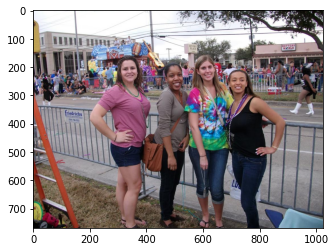

In [ ]:
model = create_TinyX5_model()
model.summary()
optimizer = Adam(learning_rate=1e-4, clipnorm=0.001)
# model.load_weights('MyDrive/MyDrive/full_yolo_raccoon.h5')

train_num_batch = 213

# model = tf.keras.models.load_model("my_model", compile=False)

epochs = 10
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch in enumerate(train_ds):
        if step == train_num_batch:
            break
        b_batch, y_batch = get_batch_labels(step)
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = custom_loss(y_batch, logits, b_batch)
            print('step: ', step, ' loss: ', loss_value.numpy())

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        # print(model.trainable_weights)
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))

model.save("my_model")
model = tf.keras.models.load_model("my_model", compile=False)
def predict(image):
        image_h, image_w, _ = image.shape
        image = cv2.resize(image, (416, 416), interpolation=cv2.INTER_CUBIC)
        image = image / 255.

        input_image = image[:,:,::-1]
        input_image = np.expand_dims(input_image, 0)

        netout = model.predict(input_image)[0]
        boxes  = decode_netout(netout, ANCHORS, 1)

        return boxes

image = cv2.imread('WiderSelected/train/0--Parade/0_Parade_Parade_0_109.jpg')
boxes = predict(image)
image = draw_boxes(image, boxes,['face'])
plt.imshow(image[:,:,::-1])
print(len(boxes), 'boxes are found')


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def get_model():
    # Create a simple model.
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model


model = get_model()

# Train the model.
test_input = np.random.random((128, 32))
test_target = np.random.random((128, 1))
model.fit(test_input, test_target)

# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("my_model")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("my_model")

# Let's check:
np.testing.assert_allclose(
    model.predict(test_input), reconstructed_model.predict(test_input)
)

# The reconstructed model is already compiled and has retained the optimizer
# state, so training can resume:
reconstructed_model.fit(test_input, test_target)


4/4 [==============================] - 0s 5ms/step - loss: 0.7641
INFO:tensorflow:Assets written to: my_model/assets
4/4 [==============================] - 0s 3ms/step - loss: 0.6770
